In [115]:
import numpy as np
import glob 
import pickle
import datetime
import matplotlib.pyplot as plt
from matplotlib.path import Path
import cmocean.cm as cm
from os import path
from matplotlib.tri import Triangulation,TriFinder
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull

%matplotlib inline

In [95]:
def get_z(rg,tg,data,t,N):
    z = np.zeros_like(rg) * np.nan
    for ind,n in enumerate(sorted(list(data.keys()))[::-1]):
        xy = data[n]['xy'][t][:,0]
        r = np.sqrt(xy.real**2. + xy.imag**2.)
        theta = np.arctan2(xy.real,xy.imag) * 180./np.pi
        theta[theta < 0.] += 360.
        tgp = tg
        if theta.max() - theta.min() > 350.:
            theta[theta < 0.] += 360.
            theta[theta > 270.] -= 360.
                
        if len(r) == 1:
            d = np.sqrt((rg - r)**2. + (tgp - theta)**2.)
            j,i = np.where(d == np.nanmin(d))
            z[j,i] = ind / (len(data))# + 1)
        else:
            trif = Triangulation(r,theta).get_trifinder()
            for j in range(N):
                for i in range(N):
                    if trif(rg[j,i],tgp[j,i]) != -1:
                        z[j,i] = ind / (len(data))# + 1)
                        
    return z

In [193]:
def get_z(xg,yg,data,t,N,subset=100,fac=4):
    z = np.zeros_like(xg) * np.nan
    positions = {}
    for ind,n in enumerate(sorted(list(data.keys()))[::-1]):
        xy = data[n]['xy'][t][:,0]
        pts = np.column_stack([xy.real,xy.imag])
        positions[n] = pts
        (i0,i1) = (0,subset)
        (j0,j1) = (0,subset)
        jsteps = np.arange(xg.shape[0])[::int(subset/fac)]
        isteps = np.arange(xg.shape[1])[::int(subset/fac)]
        for j0,j1 in zip(jsteps[:-fac],jsteps[fac:]): 
            jslice = slice(int(j0),int(j1+1),None)
            for i0,i1 in zip(isteps[:-fac],isteps[fac:]):
                islice = slice(int(i0),int(i1+1),None)
                xx = xg[jslice,islice]
                yy = yg[jslice,islice]
                zz = z[jslice,islice]
                bb = np.array([
                    [xx[0,0],yy[0,0]],
                    [xx[-1,0],yy[-1,0]],
                    [xx[-1,-1],yy[-1,-1]],
                    [xx[0,-1],yy[0,-1]],
                    [xx[0,0],yy[0,0]]
                ])
                bbp = Path(bb)
                if np.sum(bbp.contains_points(pts)) == 0:
                    continue
                sub_pts = pts[bbp.contains_points(pts),:]
                if sub_pts.shape[0] > 2:
                    hull = ConvexHull(sub_pts)
                    sub_pts_verts = sub_pts[hull.vertices,:]
                    sub_path = Path(sub_pts_verts)
                    for j in range(subset):
                        for i in range(subset):
                            if sub_path.contains_point((xx[j,i],yy[j,i])):
                                zz[j,i] = ind / len(data)
                    z[jslice,islice] = zz
                        
    return z,positions

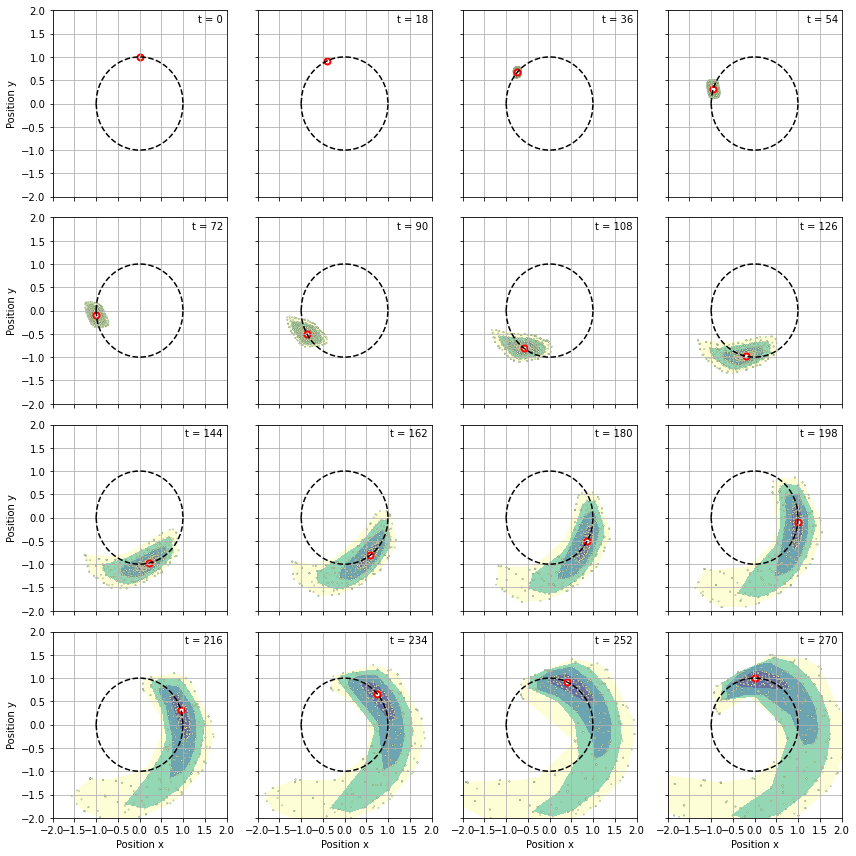

In [201]:
ext = 3.
N = 751
resg = 2. * ext / N

dt = 270.
res = 100.
npl = 7
fd = 15
npg = 32
    
f = 'D:/iCloudDrive/Thesis/rerun_sensitivity_202209/constant_results/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
with open(f,'rb') as fid:
    data = pickle.load(fid,encoding='latin-1')

runtime = data['runtime']
del data['runtime']
NN = len(data[0.1]['xy'])
    
fig,axes = plt.subplots(4,4,sharey='row',sharex='col',figsize=(12,12))
xg,yg = np.meshgrid(np.linspace(-ext,ext,N),np.linspace(-ext,ext,N))
rg = np.sqrt(xg**2. + yg**2.)
tg = np.arctan2(xg,yg) * 180./np.pi
tg[tg < 0.] += 360.

for t,ax in zip(np.arange(NN)[::int(NN/16)+2],axes.ravel()):
    z,positions = get_z(xg,yg,data,t,N,subset=150,fac=3)
    ax.text(0.98,0.98,'t = %1i'%(t+0),ha='right',va='top',transform=ax.transAxes)
    ax.plot(np.linspace(-1.,1.,100),np.sqrt(1. - np.linspace(-1.,1.,100)**2.),color='k',ls='--')
    ax.plot(np.linspace(-1.,1.,100),-np.sqrt(1. - np.linspace(-1.,1.,100)**2.),color='k',ls='--')
    pc = ax.pcolormesh(xg,yg,z,cmap=cm.deep,vmin=0.,vmax=1.,shading='auto',alpha=0.8)
    for m in positions.keys():
        ax.scatter(positions[m][:,0],positions[m][:,1],c=np.ones_like(positions[m][:,0])*float(m),
                   cmap=cm.deep,vmin=0.,vmax=1.,marker='o',edgecolor='k',s=2,lw=0.1)
    
    thc = np.pi/2. + t * 2.*np.pi / dt
    ax.scatter(np.cos(thc),np.sin(thc),marker='o',facecolor='w',edgecolor='r',lw=2)
    ax.grid(which='both')
    ax.set_xlim(-2.,2.)
    ax.set_ylim(-2.,2.)
    
for a in axes[:,0]:
    a.set_yticks(np.arange(-2.,2.1,0.5))
    a.set_ylabel('Position y')
                  
for a in axes[-1,:]:
    a.set_xticks(np.arange(-2.,2.1,0.5))
    a.set_xlabel('Position x')
    
plt.tight_layout()
plt.savefig('D:/iCloudDrive/Thesis/Figures/fig5_steady_trackplot.png',dpi=450)

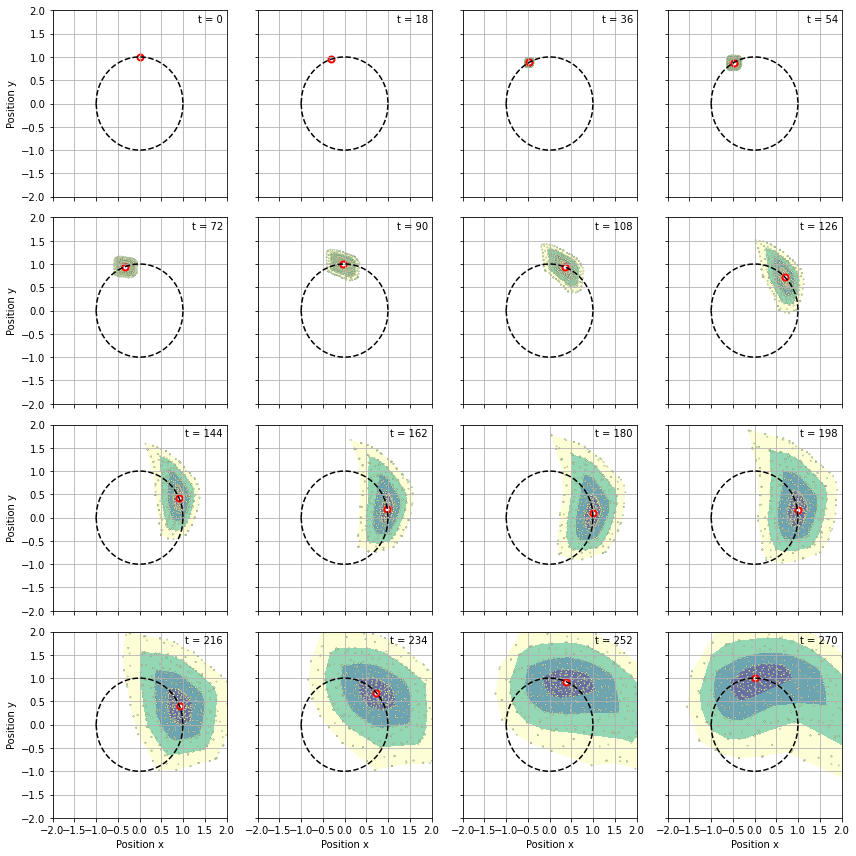

In [219]:
ext = 3.
N = 751
resg = 2. * ext / N

dt = 270.
res = 100.
npl = 7
fd = 15
npg = 32
    
f = 'D:/iCloudDrive/Thesis/rerun_sensitivity_202209/wave_results/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
with open(f,'rb') as fid:
    data = pickle.load(fid,encoding='latin-1')
runtime = data['runtime']
del data['runtime']

fc = 'D:/iCloudDrive/Thesis/rerun_sensitivity_202209/wave_results/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,1,1,10)
with open(fc,'rb') as fid:
    datac = pickle.load(fid,encoding='latin-1')
runtime = datac['runtime']
del datac['runtime']
xyc = datac[0.]['xy']

NN = len(data[0.1]['xy'])
    
fig,axes = plt.subplots(4,4,sharey='row',sharex='col',figsize=(12,12))
xg,yg = np.meshgrid(np.linspace(-ext,ext,N),np.linspace(-ext,ext,N))
rg = np.sqrt(xg**2. + yg**2.)
tg = np.arctan2(xg,yg) * 180./np.pi
tg[tg < 0.] += 360.

for t,ax in zip(np.arange(NN)[::int(NN/16)+2],axes.ravel()):
    z,positions = get_z(xg,yg,data,t,N,subset=150,fac=3)
    ax.text(0.98,0.98,'t = %1i'%(t+0),ha='right',va='top',transform=ax.transAxes)
    ax.plot(np.linspace(-1.,1.,100),np.sqrt(1. - np.linspace(-1.,1.,100)**2.),color='k',ls='--')
    ax.plot(np.linspace(-1.,1.,100),-np.sqrt(1. - np.linspace(-1.,1.,100)**2.),color='k',ls='--')
    pc = ax.pcolormesh(xg,yg,z,cmap=cm.deep,vmin=0.,vmax=1.,shading='auto',alpha=0.8)
    for m in positions.keys():
        ax.scatter(positions[m][:,0],positions[m][:,1],c=np.ones_like(positions[m][:,0])*float(m),
                   cmap=cm.deep,vmin=0.,vmax=1.,marker='o',edgecolor='k',s=2,lw=0.1)
    
    ax.scatter(xyc[t][:,0].real,xyc[t][:,0].imag,marker='o',facecolor='w',edgecolor='r',lw=2)
    ax.grid(which='both')
    ax.set_xlim(-2.,2.)
    ax.set_ylim(-2.,2.)
    
for a in axes[:,0]:
    a.set_yticks(np.arange(-2.,2.1,0.5))
    a.set_ylabel('Position y')
                  
for a in axes[-1,:]:
    a.set_xticks(np.arange(-2.,2.1,0.5))
    a.set_xlabel('Position x')
    
plt.tight_layout()
plt.savefig('D:/iCloudDrive/Thesis/Figures/fig8_unsteady_trackplot.png',dpi=450)

In [220]:
ext = 3.
N = 751
resg = 2. * ext / N

dt = 270.
res = 100.
npl = 11
fd = 13
npg = 64
    
f = 'D:/iCloudDrive/Thesis/rerun_sensitivity_202209/wave_results/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
with open(f,'rb') as fid:
    data = pickle.load(fid,encoding='latin-1')
runtime = data['runtime']
del data['runtime']

fc = 'D:/iCloudDrive/Thesis/rerun_sensitivity_202209/wave_results/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,1,1,10)
with open(fc,'rb') as fid:
    datac = pickle.load(fid,encoding='latin-1')
runtime = datac['runtime']
del datac['runtime']
xyc = datac[0.]['xy']

NN = len(data[0.1]['xy'])
    
fig,axes = plt.subplots(4,4,sharey='row',sharex='col',figsize=(12,12))
xg,yg = np.meshgrid(np.linspace(-ext,ext,N),np.linspace(-ext,ext,N))
rg = np.sqrt(xg**2. + yg**2.)
tg = np.arctan2(xg,yg) * 180./np.pi
tg[tg < 0.] += 360.

for t,ax in zip(np.arange(NN)[::int(NN/16)+2],axes.ravel()):
    z,positions = get_z(xg,yg,data,t,N,subset=150,fac=3)
    ax.text(0.98,0.98,'t = %1i'%(t+0),ha='right',va='top',transform=ax.transAxes)
    ax.plot(np.linspace(-1.,1.,100),np.sqrt(1. - np.linspace(-1.,1.,100)**2.),color='k',ls='--')
    ax.plot(np.linspace(-1.,1.,100),-np.sqrt(1. - np.linspace(-1.,1.,100)**2.),color='k',ls='--')
    pc = ax.pcolormesh(xg,yg,z,cmap=cm.deep,vmin=0.,vmax=1.,shading='auto',alpha=0.8)
    for m in positions.keys():
        ax.scatter(positions[m][:,0],positions[m][:,1],c=np.ones_like(positions[m][:,0])*float(m),
                   cmap=cm.deep,vmin=0.,vmax=1.,marker='o',edgecolor='k',s=2,lw=0.1)
    
    ax.scatter(xyc[t][:,0].real,xyc[t][:,0].imag,marker='o',facecolor='w',edgecolor='r',lw=2)
    ax.grid(which='both')
    ax.set_xlim(-2.,2.)
    ax.set_ylim(-2.,2.)
    
for a in axes[:,0]:
    a.set_yticks(np.arange(-2.,2.1,0.5))
    a.set_ylabel('Position y')
                  
for a in axes[-1,:]:
    a.set_xticks(np.arange(-2.,2.1,0.5))
    a.set_xlabel('Position x')
    
plt.tight_layout()
#plt.savefig('D:/iCloudDrive/Thesis/Figures/fig8_unsteady_trackplot.png',dpi=450)

In [ ]:
ext = 1.5
N = 500
resg = 2. * ext / N

res = 100.
npl = 7
fd = 15
npg = 32

dt = 270.
    
f = 'D:/rerun_sensitivity_202209/constant_results/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
with open(f,'rb') as fid:
    data = pickle.load(fid,encoding='latin-1')

runtime = data['runtime']
del data['runtime']
N = len(data[0.1]['xy'])
    
fig,axes = plt.subplots(4,4,sharey='row',sharex='col',figsize=(12,12))
xg,yg = np.meshgrid(np.linspace(-ext,ext,N),np.linspace(-ext,ext,N))
rg = np.sqrt(xg**2. + yg**2.)
tg = np.arctan2(xg,yg) * 180./np.pi

for t,ax in zip(np.arange(N)[::int(N/16)+1],axes.ravel()):
    z = np.zeros_like(xg) * np.nan
    for ind,n in enumerate(sorted(list(data.keys()))[::-1]):
        #xy = data[n]['xy'][len(data[n]['xy']) - 1][:,0]
        xy = data[n]['xy'][t][:,0]
        r = np.sqrt(xy.real**2. + xy.imag**2.)
        theta = np.arctan2(xy.real,xy.imag) * 180./np.pi
        tgp = tg
        if theta.max() - theta.min() > 315.:
            theta[theta < -90.] += 360.
            tgp[tgp < -90.] += 360.
            
        try:
            trif = Triangulation(r,theta).get_trifinder()
            for j in range(N):
                for i in range(N):
                    if trif(rg[j,i],tgp[j,i]) != -1:
                        z[j,i] = ind / (len(data) + 1)
        except:
            if len(r) == 1:
                #print(ind,r,theta)
                d = np.sqrt((rg - r)**2. + (tgp - theta)**2.)
                j,i = np.where(d == np.nanmin(d))
                z[j,i] = ind / (len(data) + 1)
            else:
                print('Something unexpected happened with the triangulation for %s on level %.2f'%(f.split('/')[-1],ind))
    ax.text(0.98,0.98,'t = %1i'%(t+1),ha='right',va='top',transform=ax.transAxes)
    ax.plot(np.linspace(-1.,1.,100),np.sqrt(1. - np.linspace(-1.,1.,100)**2.),color='k',ls='--')
    ax.plot(np.linspace(-1.,1.,100),-np.sqrt(1. - np.linspace(-1.,1.,100)**2.),color='k',ls='--')
    pc = ax.pcolormesh(xg,yg,z,cmap=cm.deep,vmin=0.,vmax=1.,shading='auto',alpha=0.8)
    #plt.colorbar(pc,orientation='vertical',shrink=0.7,label='membership')
    z = z * resg**2.
    #print(npg,np.nansum(z),runtime)

In [ ]:
ext = 1.5
N = 500
resg = 2. * ext / N

xg,yg = np.meshgrid(np.linspace(-ext,ext,N),np.linspace(-ext,ext,N))
rg = np.sqrt(xg**2. + yg**2.)
tg = np.arctan2(xg,yg) * 180./np.pi

res = 100.
npl = 7
fd = 15
npg = 32
    
files1 = sorted(glob.glob('D:/rerun_sensitivity_202209/constant_results/fuzzyTrial_dt*_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(res,npg,npl,fd)))
files2 = sorted(glob.glob('D:iCloudDrive/Thesis/rerun_sensitivity_202209/constant_results/fuzzyTrial_dt*_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(res,npg,npl,fd)))

files = files1 + files2

for f in files:
    with open(f,'rb') as fid:
        data = pickle.load(fid,encoding='latin-1')

    runtime = data['runtime']
    del data['runtime']
    
    